In [ ]:
import numpy as np
import bitarray
import logging
from pybloom.pybloom import BloomFilter
from sklearn import linear_model
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import csv

In [ ]:
def initBloomFilter(stringUnique):
    '''
    keyHashMat is (hahsLenth * keyNum)
    :param stringUnique:
    :return:
    '''
    #print('---initialize Bloom Filter---')
    BF = BloomFilter(capacity=int(len(stringUnique) * 1.2), error_rate=0.9)
    keyHashMat = []
    for i in stringUnique:
        BF.add(i)
        keyHashMat.append([int(x) for x in BF.keyhash(i)])
    keyHashMat = np.mat(keyHashMat).T
    #print('BF', BF)
    #print('BF.num_bits', BF.num_bits)
    #print('BF.bitarray', BF.bitarray)
    #print('keyHashMat', keyHashMat)
    #print(keyHashMat.shape)
    return BF, BF.num_bits, BF.bitarray, keyHashMat

In [ ]:
def data2B(clientData, BF):
    '''
    :return: Bdata(reportsNUM * k), sum num bitarray(1*k)
    '''
    #print('\n---data -> B---')
    Bdata = []
    sumArray = np.array([0] * BF.num_bits)
    count = 0
    sumCount = len(clientData)
    for perClient in clientData:
        count += 1
        #if count == int(sumCount * 0.25) \
        #        or count == int(sumCount * 0.5) \
        #        or count == int(sumCount * 0.75) \
        #        or count == int(sumCount):
            #print(str(round(count / sumCount * 100, 2)) + ' %')
        for num in perClient:
            keyBitarray = BF.keyhash(num)
            keyArray = [int(x) for x in keyBitarray]
            sumArray += np.array(keyArray)
            Bdata.append(keyArray)
    #print('Bdata', Bdata)
    #print(len(Bdata))
    return Bdata, sumArray

In [ ]:
def lassoRegression(X, Y):
    '''
    :param X: hashLen*keyKindNUM
    :param Y: hashLen*1
    :return:  eachKeyNUM
    '''
    reg = linear_model.Lasso(alpha=0.1, positive=True)
    reg.fit(keyHashMat, sumMat)
    return reg.coef_


In [ ]:
def compareResult(trueNUM, predictNUM):

    stringNum = len(trueNUM)
    x = np.arange(stringNum)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(x, trueNUM, width=0.4, facecolor='#9999ff', edgecolor='white', label='True')
    ax.bar(x + 0.4, predictNUM, width=0.4, facecolor='#ff9999', edgecolor='white', label='predict')
    # ax.bar(x, trueNUM, width=0.4, facecolor='#9999ff', edgecolor='white', label='True')
    # ax.bar(x + 0.4, predictNUM, width=0.4, facecolor='#ff9999', edgecolor='white', label='predict')
    ax.set_title("compare ")
    for a, b in zip(x, trueNUM):
        plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=7)
    for a, b in zip(x, predictNUM):
        plt.text(a + 0.4, b + 800, '%.1f' % b, ha='center', va='bottom', fontsize=7)
    # plt.xlim(-500, 500)
    plt.legend()
    plt.show()

In [ ]:
def B2Bprime(Bdata, f):
    '''
    :param Bdata: (reportNum * hashLen)
    :return:
    '''
    #print('\n---B -> B\'---')
    reportNum = len(Bdata)
    hashLen = len(Bdata[0])
    BprimeData = []
    count = 0
    for i in range(reportNum):
        count += 1
        #if count == int(reportNum * 0.25) \
        #        or count == int(reportNum * 0.5) \
        #        or count == int(reportNum * 0.75) \
        #        or count == int(reportNum):
        #    #print(str(round(count / reportNum * 100, 2)) + ' %')
        newOneReport = []
        for k in range(hashLen):
            randomNum = np.random.rand()
            if randomNum <= 0.5 * f:
                eachBit = 1
            elif randomNum <= f:
                eachBit = 0
            else:
                eachBit = Bdata[i][k]
            newOneReport.append(eachBit)
        BprimeData.append(newOneReport)
    #print('BprimeData', BprimeData)
    #print(len(BprimeData))
    return BprimeData

In [ ]:
def Bprime2S(BprimeData, p, q):
    '''
    :param BprimeData: (reportNum * hashLen)
    :return:
    '''
    #print('---B\' -> S---\n')
    reportNum = len(BprimeData)
    hashLen = len(BprimeData[0])
    Sdata = []
    count = 0
    for i in range(reportNum):
        count += 1
        #if count == int(reportNum * 0.25) \
        #        or count == int(reportNum * 0.5) \
        #        or count == int(reportNum * 0.75) \
        #        or count == int(reportNum):
        #    print(str(round(count / reportNum * 100, 2)) + ' %')
        newOneReport = []
        for k in range(hashLen):
            randomNum = np.random.rand()
            if BprimeData[i][k] == 1:
                if randomNum <= q:
                    eachBit = 1
                else:
                    eachBit = 0
            if BprimeData[i][k] == 0:
                if randomNum <= p:
                    eachBit = 1
                else:
                    eachBit = 0
            newOneReport.append(eachBit)
        Sdata.append(newOneReport)
    #print('Sdata', Sdata)
    #print(len(Sdata))
    return Sdata


In [ ]:
def getPredictSumMat(Sdata, f, p, q):
    SdataMat = np.mat(Sdata)
    SumArray = np.array(np.sum(SdataMat, 0))[0]
    predictSumArray = [(x - (0.5 * f * q + p - 0.5 * f * p) * len(Sdata)) / ((1 - f) * (q - p)) for x in SumArray]
    return predictSumArray

In [ ]:
def l2distance(list1, list2):
    """Distance between two vectors."""
    squares = [(p-q) ** 2 for p, q in zip(list1, list2)]
    return sum(squares) ** .5

In [ ]:
def utilityevaluation(original, perturbed):
    num = len(original)
    l2dist = []
    for i in range(0, num):
        l2dist.append(l2distance(perturbed[i], original[i]))
    return l2dist

In [ ]:
def loadData(n):
    '''
    :return: clientData: (list clientNUm * perClientNUM)
    len(clientData): clientNUM
    len(clientData[0]): perClientReport
    stringUnique: string index
    resultList: statistic each string's number
    '''
    #print('---loadData---')
    clientData = []
    temp = {}
    result = {}
    datasize = 0
    for i in range(0,n):

        cutline = np.random.randint(30, size=(1))
        clientData.append(cutline)
        for x in cutline:
            if x not in temp:
                temp[x] = 1
            else:
                temp[x] += 1
    stringUnique = np.unique(clientData)
    for i in sorted(temp):
        result[i] = temp[i]
    resultList = [n for n in (result[i] for i in result)]
    return clientData, len(clientData), len(clientData[0]), stringUnique, resultList

In [ ]:
def loadcsv(filename,n):
    '''
    :return: clientData: (list clientNUm * perClientNUM)
    len(clientData): clientNUM
    len(clientData[0]): perClientReport
    stringUnique: string index
    resultList: statistic each string's number
    '''
    #print('---loadData---')
    file = open(filename)
    clientData = []
    temp = {}
    result = {}
    datasize = 0
    flag=0
    with open('map.csv', newline='') as csvfile:
        cutline = csv.reader(csvfile)
        for row in cutline:
            #rint(cutline)
            if flag=n:
                #cutline = spamreader.strip().split('\t')
                #print('cutline',cutline)
                #cutline = [int(x) for x in cutline]
                #print('cutline',cutline)
                clientData.append(row[:1])
                flag+=1
                for x in row[:1]:
                    if x not in temp:
                        temp[x] = 1
                    else:
                        temp[x] += 1
    stringUnique = np.unique(clientData)
    for i in sorted(temp):
        result[i] = temp[i]
    resultList = [n for n in (result[i] for i in result)]
    return clientData, len(clientData), len(clientData[0]), stringUnique, resultList

In [ ]:
filename = './map.csv'
datasetsize = [0,  400.,  3200.,  6000.,  8800., 11600., 14400., 17200., 20000.]
clientData, clientNum, perClientNum, stringUnique, resultList = loadcsv(filename,100)
BF, BFnum_bits, BFbitarray, keyHashMat = initBloomFilter(stringUnique)
Bdata, sumArray = data2B(clientData, BF)

In [ ]:
len(stringUnique)

61

In [ ]:
perClientNum

1

In [ ]:
len(clientData)

100

In [ ]:
len(Bdata)

100

## Multi View

In [ ]:
def mvrappor(epsilon,view):
    eps = epsilon / view
    p = 0 # divided by e/v
    q = 1
    f = 1 / (1+np.sqrt(eps))
    #clientData, clientNum, perClientNum, stringUnique, resultList = loadData(filename)
    #BF, BFnum_bits, BFbitarray, keyHashMat = initBloomFilter(stringUnique)
    #Bdata, sumArray = data2B(clientData, BF)
    BprimeData = B2Bprime(Bdata, f)
    Sdata = Bprime2S(BprimeData, p, q)
    predictSumArray = getPredictSumMat(Sdata, f, p, q)
    #sumMat = np.mat(predictSumArray).T
    #predictNUM = lassoRegression(keyHashMat, predictSumArray)
    #predictNUM.tolist()
    return l2distance(predictSumArray, resultList)

In [ ]:
R=10 #Repeating 
Minforeachviewnumber=[] #best result for each view number when epsilon is fixed
alleps=[]; # 10*10 matrix storing all results given by Minforeachviewnumber for all eps
#epsilon=[0.1,1,2,3,4,5,6,7,8,9,10]
singledataerror=[]
singledataeps=[]
viewnum=128
view=np.zeros(128)
w, h = viewnum, 5
dataeps = [[0 for x in range(w)] for y in range(h)]

mv=0
epsilon=[0.1,0.5,1,4,7]
singleerror=np.zeros(viewnum)
start=time.time()
for i in range(0,1000):
    print('data',i)
    clientData, clientNum, perClientNum, stringUnique, resultList = loadcsv(filename,i)
    BF, BFnum_bits, BFbitarray, keyHashMat = initBloomFilter(stringUnique)
    Bdata, sumArray = data2B(clientData, BF)
    singledataeps=[]
    singledataerror=[]
    singleerror=np.zeros(viewnum)
    for e in epsilon: #e=1:10 %for each epsilon
        error=0
        for r in range(R):
            singledataerror=[]
            for n in range(1,viewnum+1):
                bestv=10000000000
                for j in range(1,n+1):
                    xormin=mvrappor(e,n)
                    if xormin<bestv:
                        bestv=xormin
                singledataerror.append(bestv)
            singleerror=np.add(singledataerror,singleerror)
        singleerror=[k/R for k in singleerror]
        singledataeps.append(singleerror)

    dataeps = [[dataeps[ii][jj] + singledataeps[ii][jj]  for jj in range(len(dataeps[0]))] for ii in range(len(dataeps))]
        #print('singledataeps',singledataeps)
        #print('dataeps',dataeps)

end=time.time()
computationtime=(end-start)

data 0
data 1
data 2
data 3
data 4
data 5
data 6
data 7
data 8
data 9
data 10
data 11
data 12
data 13
data 14
data 15
data 16
data 17
data 18
data 19
data 20
data 21
data 22
data 23
data 24
data 25
data 26
data 27
data 28
data 29
data 30
data 31
data 32
data 33
data 34
data 35
data 36
data 37
data 38
data 39
data 40
data 41
data 42
data 43
data 44
data 45
data 46
data 47
data 48
data 49
data 50
data 51
data 52
data 53
data 54
data 55
data 56
data 57
data 58
data 59
data 60
data 61
data 62
data 63
data 64
data 65
data 66
data 67
data 68
data 69
data 70
data 71
data 72
data 73
data 74
data 75
data 76
data 77
data 78
data 79
data 80
data 81
data 82
data 83
data 84
data 85
data 86
data 87
data 88
data 89
data 90
data 91
data 92
data 93
data 94
data 95
data 96
data 97
data 98
data 99
data 100
data 101
data 102
data 103
data 104
data 105
data 106
data 107
data 108
data 109
data 110
data 111
data 112
data 113
data 114
data 115
data 116
data 117
data 118
data 119
data 120
data 121
data 122
dat

In [ ]:
computationtime

13468.002103805542

In [ ]:
newalleps=[np.log(i) for i in dataeps]

In [ ]:
xx = [i for i in range(1,129)]

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
a1 = gaussian_filter1d(newalleps[0], sigma=4)
a2 = gaussian_filter1d(newalleps[1], sigma=4)
a3 = gaussian_filter1d(newalleps[2], sigma=4)
a4 = gaussian_filter1d(newalleps[3], sigma=4)
a5 = gaussian_filter1d(newalleps[4], sigma=4)

In [ ]:
xx = [1,4,8,16,32,64,128]

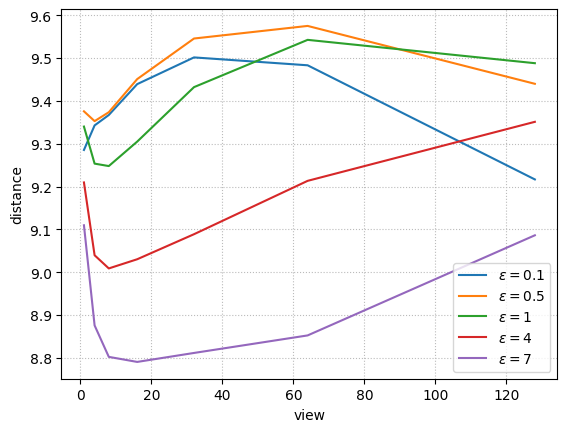

In [ ]:
import matplotlib.ticker as mticker
#x = np.linspace(1,nmax,len(N))
#f = mticker.ScalarFormatter(useOffset=False, useMathText=False)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.style.use('default')
plt.plot(xx,(newalleps[0][0],newalleps[0][3],newalleps[0][7],newalleps[0][15],newalleps[0][31],newalleps[0][63],newalleps[0][127]),label=r'$\epsilon=0.1$',color='C0')
plt.plot(xx,(newalleps[1][0],newalleps[1][3],newalleps[1][7],newalleps[1][15],newalleps[1][31],newalleps[1][63],newalleps[1][127]),label=r'$\epsilon=0.5$',color='C1')
plt.plot(xx,(newalleps[2][0],newalleps[2][3],newalleps[2][7],newalleps[2][15],newalleps[2][31],newalleps[2][63],newalleps[2][127]),label=r'$\epsilon=1$',color='C2')
plt.plot(xx,(newalleps[3][0],newalleps[3][3],newalleps[3][7],newalleps[3][15],newalleps[3][31],newalleps[3][63],newalleps[3][127]),label=r'$\epsilon=4$',color='C3')
plt.plot(xx,(newalleps[4][0],newalleps[4][3],newalleps[4][7],newalleps[4][15],newalleps[4][31],newalleps[4][63],newalleps[4][127]),label=r'$\epsilon=7$',color='C4')
#plt.plot(x,newalleps[5],label=r'$\epsilon=7$',color='C5')
#plt.plot(x,newalleps[6],label=r'$\epsilon=6$',color='C6')
#plt.plot(x,newalleps[7],label=r'$\epsilon=7$',color='C7')
plt.grid(which='major', color='#BBBBBB', linestyle=':', linewidth=0.8)
plt.xlabel('view')
plt.ylabel('distance')
plt.legend(loc="lower right")
plt.title('')
#plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('./Multiversion_Rappor_10000l1_4.pdf') 

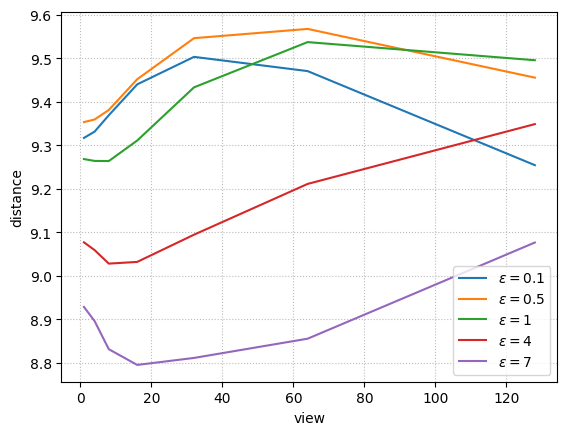

In [ ]:
import matplotlib.ticker as mticker
#x = np.linspace(1,nmax,len(N))
#f = mticker.ScalarFormatter(useOffset=False, useMathText=False)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.style.use('default')
plt.plot(xx,(a1[0],a1[3],a1[7],a1[15],a1[31],a1[63],a1[126]),label=r'$\epsilon=0.1$',color='C0')
plt.plot(xx,(a2[0],a2[3],a2[7],a2[15],a2[31],a2[63],a2[126]),label=r'$\epsilon=0.5$',color='C1')
plt.plot(xx,(a3[0],a3[3],a3[7],a3[15],a3[31],a3[63],a3[126]),label=r'$\epsilon=1$',color='C2')
plt.plot(xx,(a4[0],a4[3],a4[7],a4[15],a4[31],a4[63],a4[126]),label=r'$\epsilon=4$',color='C3')
plt.plot(xx,(a5[0],a5[3],a5[7],a5[15],a5[31],a5[63],a5[126]),label=r'$\epsilon=7$',color='C4')
#plt.plot(x,newalleps[5],label=r'$\epsilon=7$',color='C5')
#plt.plot(x,newalleps[6],label=r'$\epsilon=6$',color='C6')
#plt.plot(x,newalleps[7],label=r'$\epsilon=7$',color='C7')
plt.grid(which='major', color='#BBBBBB', linestyle=':', linewidth=0.8)
plt.xlabel('view')
plt.ylabel('distance')
plt.legend(loc="lower right")
plt.title('')
#plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('./Multiversion_Rappor_client.pdf') 